In [44]:
import collections
import numpy as np
import matplotlib.pyplot as plt

def pos_func2(t):
    pos = np.zeros_like(t)
    pos[t >= 2.5] = 5
    pos[t >= 15] = 2
    pos[t >= 30] = 3
    pos += np.sin(2*np.pi*t / 20)/2
    vel = np.pi * np.cos(2*np.pi*t / 20) / 20
    pos[(t>22) & (t<23)] = 3
    pos[(t > 35) & (t < 45)] = 3
    
    return pos, vel

def pos_func(t):
    pos = 1 + np.sin(np.pi * t / 20)
    vel = np.pi * np.cos(np.pi*t / 20) / 20
    return pos, vel


class foo:
    def __init__(self):
        self._config = {
            'speed': 2.5,
            'acceleration': 2,
            'tracking_cadence': 0.05,
            'rotation_microsteps': 200 * 16,
            'rotation_distance': 1
        }
        self._mcu_freq = 12e6
        self._stepper_oid = 2
        self._steps_per_distance = self._config['rotation_microsteps'] / self._config['rotation_distance']
        self._track_func = pos_func
        self._track_segments = collections.deque()
        self._track_end_time = 0
        self._track_end_pos = 0
        self._track_end_vel = 0
        self._track_committed_clock = 0
        self._track_committed_steps = 0
        self._track_committed_step_dir = 0

    
    def _build_trapezoidal_move(self, start_time, start_pos, start_vel, end_pos, end_vel):
        distance = abs(end_pos - start_pos)
        sign = 1 if end_pos >= start_pos else -1
        start_vel *= sign
        end_vel *= sign

        coast_speed = min(self._config['speed'], np.sqrt(0.5 * distance * self._config['acceleration']))
        acceleration_time = abs(coast_speed - start_vel) / self._config['acceleration']
        acceleration_distance = start_vel * acceleration_time + 0.5 * self._config['acceleration'] * acceleration_time ** 2
        deceleration_time = abs(end_vel - coast_speed) / self._config['acceleration']
        deceleration_distance = end_vel * deceleration_time + 0.5 * self._config['acceleration'] * deceleration_time ** 2

        coast_distance = distance - acceleration_distance - deceleration_distance
        coast_time = coast_distance / coast_speed
        total_time = acceleration_time + coast_time + deceleration_time

        def inner(t):
            if np.isscalar(t):
                return inner(np.array(t)).item()

            dt = t - start_time
            accel_filt = (dt > 0) & (dt <= acceleration_time)
            coast_filt = (dt > acceleration_time) & (dt <= acceleration_time + coast_time)
            decel_filt = (dt > acceleration_time + coast_time) & (dt <= total_time)
            after_filt = dt > total_time

            offset = np.zeros_like(t)
            offset[accel_filt] = start_vel * dt[accel_filt] + 0.5 * self._config['acceleration'] * dt[accel_filt] ** 2
            offset[coast_filt] = (dt[coast_filt] - acceleration_time) * coast_speed + acceleration_distance
            offset[decel_filt] = distance - end_vel * (total_time - dt[decel_filt]) - 0.5 * self._config['acceleration'] * (total_time - dt[decel_filt]) ** 2
            offset[after_filt] = distance
            return start_pos + sign * offset

        return inner, total_time

    def _extend_track(self, end_time):
        if self._track_func is None:
            self._track_end_time = end_time
            return

        def add_segment(next_pos, ttype):
            move_vel = (next_pos - self._track_end_pos) / self._config['tracking_cadence']
            self._track_segments.append(
                (self._track_end_time, self._track_end_pos, move_vel, self._config['tracking_cadence'], ttype))
            self._track_end_time += self._config['tracking_cadence']
            self._track_end_pos = next_pos
            self._track_end_vel = move_vel

        max_dvp = 0.5 * self._config['acceleration'] * self._config['tracking_cadence'] ** 2
        while self._track_end_time < end_time:
            next_t = self._track_end_time + self._config['tracking_cadence']
            next_pos, next_vel = self._track_func(next_t)

            next_pos_min = self._track_end_pos + self._track_end_vel * self._config['tracking_cadence'] - max_dvp
            next_pos_max = self._track_end_pos + self._track_end_vel * self._config['tracking_cadence'] + max_dvp
            if next_pos_min < next_pos <= next_pos_max:
                add_segment(next_pos, 0)
                continue
                
            converge_pos, converge_vel = next_pos, next_vel
            for i in range(25):
                move_fn, move_time = self._build_trapezoidal_move(self._track_end_time, self._track_end_pos, self._track_end_vel, converge_pos, converge_vel)
                move_complete_t = self._track_end_time + move_time
                updated_pos, updated_vel = self._track_func(move_complete_t)

                if abs(updated_pos - converge_pos) < 1 / self._steps_per_distance:
                    break

                converge_pos = updated_pos
                converge_vel = updated_vel

            print(
            while next_t < move_complete_t + self._config['tracking_cadence']:
                add_segment(move_fn(next_t), 1)
                next_t += self._config['tracking_cadence']

    def commit_track_segments(self, end_time):
        while len(self._track_segments) and self._track_segments[0][0] < end_time:
            start_t, start_pos, velocity, length, mode = self._track_segments.popleft()
            start_steps = int(start_pos * self._steps_per_distance + 0.5)
            end_steps = int((start_pos + velocity * length) * self._steps_per_distance + 0.5)
            count = abs(end_steps - start_steps)
            if count == 0:
                continue

            start_clock = int(start_t * self._mcu_freq)
            end_clock = int((start_t + length) * self._mcu_freq)

            step_dir = 1 if velocity > 0 else 0
            step_sign = 1 if velocity > 0 else -1
            if step_dir != self._track_committed_step_dir:
                yield f'set_next_step_dir oid={self._stepper_oid} dir={step_dir}'
                self._track_committed_step_dir = step_dir

            # Reset step clock if we have been paused, allowing
            # for small rounding errors from the last segment
            if start_clock > self._track_committed_clock + 2 * count:
                if count == 1:
                    yield f'queue_step oid={self._stepper_oid} interval={end_clock - self._track_committed_clock} count=1 add=0'
                    self._track_committed_clock = end_clock
                    self._track_committed_steps += step_sign
                    continue

                yield f'queue_step oid={self._stepper_oid} interval={start_clock - self._track_committed_clock} count=1 add=0'
                self._track_committed_clock = start_clock
                self._track_committed_steps += step_sign
                count -= 1


            interval = int((end_clock - self._track_committed_clock) / count)

            yield f'queue_step oid={self._stepper_oid} interval={interval} count={count} add=0'
            self._track_committed_clock += count * interval
            self._track_committed_steps += step_sign * count


test = foo()
test._extend_track(55)

dt = 0.01
pos_t = np.arange(0,50, dt)
set_p = pos_func(pos_t)[0]
step_p = np.zeros_like(pos_t)
step_type = np.zeros_like(pos_t)
for t, pos, vel, interval, ttype in test._track_segments:
    filt = (pos_t > t) & (pos_t <= t + interval)
    step_p[filt] = pos + vel * (pos_t[filt] - t)
    step_type[filt] = ttype

clocks = [0]
steps = [0]
current_step_dir = 1
commands = test.commit_track_segments(55)
for c in commands:
    parts = c.split()
    if parts[0] == 'set_next_step_dir':
        current_step_dir = 1 if parts[2] == 'dir=1' else -1
    if parts[0] == 'queue_step':
        interval = int(parts[2].split('=')[1])
        count = int(parts[3].split('=')[1])
        for i in range(count):
            clocks.append(clocks[-1] + interval)
            steps.append(steps[-1] + current_step_dir)

clocks = np.array(clocks)
steps = np.array(steps)
#markers = np.array(markers)

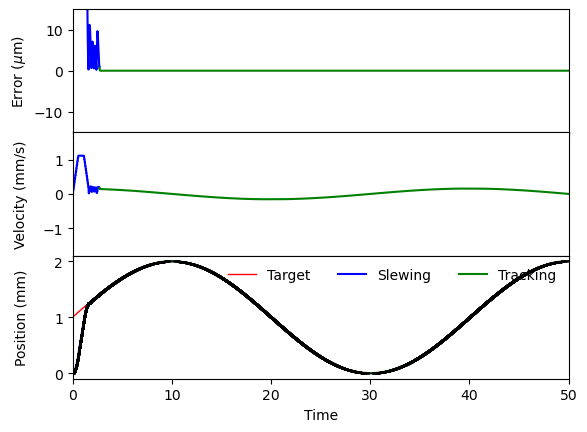

In [45]:

def plot_types(ax, x, y, t):
    start_i = 0
    for i in range(1, len(x)):
        fmt = ['g-', 'b-', 'y-']
        if t[i] != t[start_i]:
            ax.plot(x[start_i:i], y[start_i:i], fmt[int(t[start_i])])
            start_i = i-1

    ax.plot(x[start_i:], y[start_i:], fmt[int(t[start_i])])
    ax.plot([], [], 'b-', label='Slewing')
    ax.plot([], [], 'g-', label='Tracking')

from matplotlib.gridspec import GridSpec
fig = plt.figure()
gs = GridSpec(3, 1, hspace=0)
ax = plt.subplot(gs[0])
plot_types(ax, pos_t, 1000*(set_p-step_p), step_type)
ax.set_xlim(0, 50)
ax.set_ylim(-15, 15)
ax.set_xticklabels([])
ax.set_ylabel('Error ($\mu$m)')

ax = plt.subplot(gs[1])
plot_types(ax, pos_t[1:], np.diff(step_p) / dt, step_type[1:])

ax.set_xticklabels([])
ax.set_xlim(0, 50)
ax.set_ylim(-1.8, 1.8)
ax.set_ylabel('Velocity (mm/s)')

ax = plt.subplot(gs[2])
ax.plot(pos_t, set_p, 'r-', label='Target', lw=1)
plot_types(ax, pos_t, step_p, step_type)
plt.plot(clocks / test._mcu_freq, steps / test._steps_per_distance, 'k.', ms=1)
ax.set_xlim(0, 50)
ax.legend(frameon=False, loc=1, ncol=3)
ax.set_xlabel('Time')
ax.set_ylabel('Position (mm)')
fig.align_ylabels()


In [77]:
import collections
import numpy as np
import matplotlib.pyplot as plt

def pos_func2(t):
    pos = np.zeros_like(t)
    pos[t >= 2.5] = 5
    pos[t >= 15] = 2
    pos[t >= 30] = 3
    pos += np.sin(2*np.pi*t / 20)/2
    vel = np.pi * np.cos(2*np.pi*t / 20) / 20
    pos[(t>22) & (t<23)] = 3
    pos[(t > 35) & (t < 45)] = 3
    
    return pos

def pos_func3(t):
    pos = 1 + np.sin(np.pi * t / 20)
    vel = np.pi * np.cos(np.pi*t / 20) / 20
    return pos

def pos_func(t):
    pos = 2 + 2*np.sin(np.pi * t / 10)
    return pos

class foo:
    def __init__(self):
        self._config = {
            'speed': 2.5,
            'acceleration': 0.5,
            'tracking_cadence': 0.01,
            'rotation_microsteps': 200 * 16,
            'rotation_distance': 1,
            'position_min': 0,
            'position_max': 50
        }
        self._mcu_freq = 12e6
        self._stepper_oid = 2
        self._steps_per_distance = self._config['rotation_microsteps'] / self._config['rotation_distance']
        self._track_func = pos_func
        self._track_segments = collections.deque()
        self._track_end_time = 0
        self._track_end_pos = 0
        self._track_end_vel = 0
        self._track_committed_clock = 0
        self._track_committed_steps = 0
        self._track_committed_step_dir = 0

    
    def _build_trapezoidal_move(self, start_time, start_pos, start_vel, end_pos, end_vel):
        distance = abs(end_pos - start_pos)
        sign = 1 if end_pos >= start_pos else -1
        start_vel *= sign
        end_vel *= sign

        coast_speed = min(self._config['speed'], np.sqrt(0.5 * distance * self._config['acceleration']))
        acceleration_time = abs(coast_speed - start_vel) / self._config['acceleration']
        acceleration_distance = start_vel * acceleration_time + 0.5 * self._config['acceleration'] * acceleration_time ** 2
        deceleration_time = abs(end_vel - coast_speed) / self._config['acceleration']
        deceleration_distance = end_vel * deceleration_time + 0.5 * self._config['acceleration'] * deceleration_time ** 2

        coast_distance = distance - acceleration_distance - deceleration_distance
        coast_time = coast_distance / coast_speed
        total_time = acceleration_time + coast_time + deceleration_time

        def inner(t):
            if np.isscalar(t):
                return inner(np.array(t)).item()

            dt = t - start_time
            accel_filt = (dt > 0) & (dt <= acceleration_time)
            coast_filt = (dt > acceleration_time) & (dt <= acceleration_time + coast_time)
            decel_filt = (dt > acceleration_time + coast_time) & (dt <= total_time)
            after_filt = dt > total_time

            offset = np.zeros_like(t)
            offset[accel_filt] = start_vel * dt[accel_filt] + 0.5 * self._config['acceleration'] * dt[accel_filt] ** 2
            offset[coast_filt] = (dt[coast_filt] - acceleration_time) * coast_speed + acceleration_distance
            offset[decel_filt] = distance - end_vel * (total_time - dt[decel_filt]) - 0.5 * self._config['acceleration'] * (total_time - dt[decel_filt]) ** 2
            offset[after_filt] = distance
            return start_pos + sign * offset

        return inner, total_time

    def _extend_track(self, track_func):
        # Calculated track state
        track_segments = collections.deque()
        start_time = 0
        start_pos = 0
        start_vel = 0
        tdt = self._config['tracking_cadence']
        pos_min = self._config['position_min']
        pos_max = self._config['position_max']

        while start_time < 55:
            end_time = start_time + tdt
            # The goal here is to solve for the velocity
            # that will get us to the target position in tdt
            # seconds from now
            end_pos = np.clip(track_func(end_time), pos_min, pos_max)
            tracking_vel = (end_pos - start_pos) / tdt
            if abs(tracking_vel - start_vel) < self._config['acceleration'] * tdt:
                # We are tracking the target
                track_segments.append((start_time, start_pos, end_time, end_pos, 1))
                start_time = end_time
                start_pos = end_pos
                start_vel = tracking_vel
                continue

            converge_pos, converge_vel = end_pos, start_vel
            for _ in range(25):
                move_fn, move_time, *_ = self._build_trapezoidal_move(
                    start_time, start_pos, start_vel, converge_pos, converge_vel)

                move_steps = int(np.ceil(move_time / tdt))
                while True:
                    after_move_start_pos = np.clip(track_func(start_time + move_steps * tdt), pos_min, pos_max)
                    after_move_end_pos = np.clip(track_func(start_time + (move_steps + 1) * tdt), pos_min, pos_max)
                    after_move_tracking_vel = (after_move_end_pos - after_move_start_pos) / tdt

                    if abs(after_move_tracking_vel) < self._config['speed']:
                        break

                    move_steps += 1

                if abs(after_move_start_pos - converge_pos) < 1 / self._steps_per_distance:
                    break

                converge_pos, converge_vel = after_move_start_pos, after_move_tracking_vel

            for i in range(move_steps):
                move_start_time = start_time + i * tdt
                move_end_time = move_start_time + tdt
                move_start_pos = move_fn(move_start_time)
                move_end_pos = move_fn(move_end_time)
                track_segments.append((move_start_time, move_start_pos, move_end_time, move_end_pos, 0))

            start_time = move_end_time
            start_pos = move_end_pos
            start_vel = (move_end_pos - move_start_pos) / tdt
        return track_segments

    def commit_track_segments(self, end_time):
        while len(self._track_segments) and self._track_segments[0][0] < end_time:
            start_t, start_pos, velocity, length, mode = self._track_segments.popleft()
            start_steps = int(start_pos * self._steps_per_distance + 0.5)
            end_steps = int((start_pos + velocity * length) * self._steps_per_distance + 0.5)
            count = abs(end_steps - start_steps)
            if count == 0:
                continue

            start_clock = int(start_t * self._mcu_freq)
            end_clock = int((start_t + length) * self._mcu_freq)

            step_dir = 1 if velocity > 0 else 0
            step_sign = 1 if velocity > 0 else -1
            if step_dir != self._track_committed_step_dir:
                yield f'set_next_step_dir oid={self._stepper_oid} dir={step_dir}'
                self._track_committed_step_dir = step_dir

            # Reset step clock if we have been paused, allowing
            # for small rounding errors from the last segment
            if start_clock > self._track_committed_clock + 2 * count:
                if count == 1:
                    yield f'queue_step oid={self._stepper_oid} interval={end_clock - self._track_committed_clock} count=1 add=0'
                    self._track_committed_clock = end_clock
                    self._track_committed_steps += step_sign
                    continue

                yield f'queue_step oid={self._stepper_oid} interval={start_clock - self._track_committed_clock} count=1 add=0'
                self._track_committed_clock = start_clock
                self._track_committed_steps += step_sign
                count -= 1


            interval = int((end_clock - self._track_committed_clock) / count)

            yield f'queue_step oid={self._stepper_oid} interval={interval} count={count} add=0'
            self._track_committed_clock += count * interval
            self._track_committed_steps += step_sign * count


test = foo()

dt = 0.01
pos_t = np.arange(0,50, dt)
set_p = pos_func(pos_t)
step_p = np.zeros_like(pos_t)
step_type = np.zeros_like(pos_t)
for start_t, start_pos, end_t, end_pos, ttype in test._extend_track(pos_func):
    filt = (pos_t >= start_t) & (pos_t <= end_t)
    step_p[filt] = start_pos + (end_pos - start_pos) * (pos_t[filt] - start_t) / (end_t - start_t)
    step_type[filt] = ttype

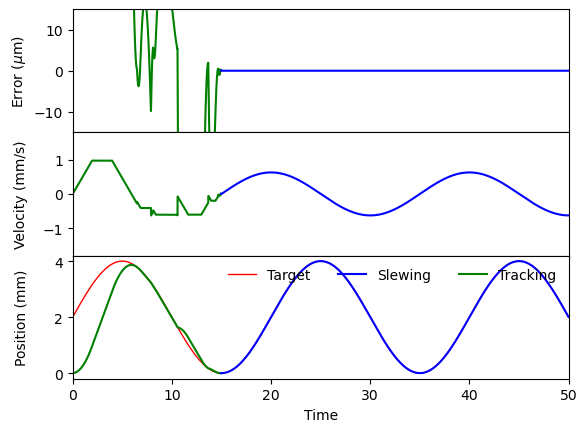

In [78]:

from matplotlib.gridspec import GridSpec
fig = plt.figure()
gs = GridSpec(3, 1, hspace=0)
ax = plt.subplot(gs[0])
plot_types(ax, pos_t, 1000*(set_p-step_p), step_type)
ax.set_xlim(0, 50)
ax.set_ylim(-15, 15)
ax.set_xticklabels([])
ax.set_ylabel('Error ($\mu$m)')

ax = plt.subplot(gs[1])
plot_types(ax, pos_t[1:], np.diff(step_p) / dt, step_type[1:])

ax.set_xticklabels([])
ax.set_xlim(0, 50)
ax.set_ylim(-1.8, 1.8)
ax.set_ylabel('Velocity (mm/s)')

ax = plt.subplot(gs[2])
ax.plot(pos_t, set_p, 'r-', label='Target', lw=1)
plot_types(ax, pos_t, step_p, step_type)
ax.set_xlim(0, 50)
ax.legend(frameon=False, loc=1, ncol=3)
ax.set_xlabel('Time')
ax.set_ylabel('Position (mm)')
fig.align_ylabels()
